In [61]:
import numpy as np
import pandas as pd
import math
import torch
import transformers as ppb
import warnings
import re
warnings.filterwarnings('ignore')

In [62]:
dfs = pd.read_excel("nlp_path_data.xlsx")
#dfs = dfs.rename(columns={'10000194': 'numbers', 'S19-09556': 'code', "Invasive carcinoma of no special type (invasive ductal carcinoma, not otherwise ...": "descriptions"})

In [63]:
dfs.head()

,Dx,Code
0,Adenocarcinoma,8140
1,Adenocarcinoma,8140
2,Adenocarcinoma,8140
3,Adenocarcinoma,8140
4,Adenocarcinoma,8140


In [64]:
np.unique(dfs["Code"])
print(len(np.unique(dfs["Code"])))

117


In [65]:
dfs["Code"].value_counts()

8500    1563
8140     827
8550     796
8070     325
8120     294
        ... 
8815       1
9020       1
8840       1
8900       1
9064       1
Name: Code, Length: 117, dtype: int64

In [66]:
# Codes we actually want to use:
df_grouped = dfs.groupby(["Code"]).count().reset_index()
codes = df_grouped[df_grouped["Dx"] > 10]["Code"].values
codes

array([8000, 8010, 8020, 8050, 8070, 8071, 8072, 8085, 8120, 8130, 8140,
       8144, 8150, 8170, 8230, 8240, 8250, 8252, 8260, 8310, 8312, 8317,
       8335, 8340, 8380, 8441, 8442, 8461, 8480, 8500, 8510, 8520, 8522,
       8550, 8575, 8720, 8721, 8742, 8743, 8744, 8745, 8802, 8850, 8858,
       8890, 8936, 9061, 9070, 9071])

In [67]:
dfs = dfs[dfs["Code"].isin(codes)]
dfs

,Dx,Code
0,Adenocarcinoma,8140
1,Adenocarcinoma,8140
2,Adenocarcinoma,8140
3,Adenocarcinoma,8140
4,Adenocarcinoma,8140
...,...,...
6792,Squamous Cell Carcinoma and Variants,8070
6793,"Squamous cell carcinoma, conventional",8070
6794,Ductal carcinoma in situ,8500
6795,Serous carcinoma,8441


In [68]:
dfs["Code"].value_counts()

8500    1563
8140     827
8550     796
8070     325
8120     294
8312     237
8050     213
8743     204
8441     184
8380     181
8520     174
8000     173
8480     118
8130     115
8720      96
8010      85
8522      71
8936      70
8260      66
8150      58
8721      47
8240      47
8071      46
8744      44
8340      38
8850      34
8742      31
8170      27
8745      26
8072      25
8317      24
8461      20
8230      19
9061      19
8802      18
8575      17
8858      16
8250      15
8252      15
8020      15
8442      14
8890      14
8085      13
8335      13
9070      13
8310      13
9071      12
8510      12
8144      11
Name: Code, dtype: int64

# Preprocessing:

In [69]:
#remove non-alphabetical characters, lower case, puctuation, extra spaces. 
dfs["Dx"] = dfs["Dx"].str.lower()
dfs["Dx"] = dfs["Dx"].replace(r'[^a-z|\s]', '', regex=True)
dfs["Dx"] = dfs["Dx"].replace(r'\s\s+', ' ', regex=True)


# BERT Embedding

In [70]:
#Load the pretrained bert model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [71]:
dfs

,Dx,Code
0,adenocarcinoma,8140
1,adenocarcinoma,8140
2,adenocarcinoma,8140
3,adenocarcinoma,8140
4,adenocarcinoma,8140
...,...,...
6792,squamous cell carcinoma and variants,8070
6793,squamous cell carcinoma conventional,8070
6794,ductal carcinoma in situ,8500
6795,serous carcinoma,8441


In [72]:
#icd_codes = dfs["preprocessed_ICD_codes"]
icd_codes_d = {}
for i, code in sorted(enumerate(set(dfs["Code"]))):
  icd_codes_d[code] = i
icd_codes_d

{8070: 0,
 8071: 1,
 8072: 2,
 8461: 3,
 8335: 4,
 8720: 5,
 8721: 6,
 8850: 7,
 8340: 8,
 8085: 9,
 8858: 10,
 8480: 11,
 8742: 12,
 8743: 13,
 8744: 14,
 8745: 15,
 8230: 16,
 8240: 17,
 8500: 18,
 8120: 19,
 8890: 20,
 8250: 21,
 8380: 22,
 8252: 23,
 8510: 24,
 8000: 25,
 8130: 26,
 8260: 27,
 8520: 28,
 8010: 29,
 8522: 30,
 8140: 31,
 8144: 32,
 8020: 33,
 8150: 34,
 8802: 35,
 9061: 36,
 8550: 37,
 8936: 38,
 8170: 39,
 9070: 40,
 9071: 41,
 8050: 42,
 8310: 43,
 8312: 44,
 8441: 45,
 8442: 46,
 8317: 47,
 8575: 48}

In [73]:
dfs['Code_n'] = dfs['Code'].apply(lambda x: icd_codes_d[x])
dfs['Code_n']

0       31
1       31
2       31
3       31
4       31
        ..
6792     0
6793     0
6794    18
6795    45
6796    37
Name: Code_n, Length: 6508, dtype: int64

In [74]:
dfs

,Dx,Code,Code_n
0,adenocarcinoma,8140,31
1,adenocarcinoma,8140,31
2,adenocarcinoma,8140,31
3,adenocarcinoma,8140,31
4,adenocarcinoma,8140,31
...,...,...,...
6792,squamous cell carcinoma and variants,8070,0
6793,squamous cell carcinoma conventional,8070,0
6794,ductal carcinoma in situ,8500,18
6795,serous carcinoma,8441,45


In [75]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dfs, test_size=0.2)

In [76]:
train = train.reset_index(drop = True)
train

,Dx,Code,Code_n
0,acinar adenocarcinoma,8550,37
1,squamous cell carcinoma usual type,8070,0
2,invasive carcinoma of no special type invasive...,8500,18
3,adenocarcinoma,8140,31
4,invasive adenocarcinoma acinar predominant,8140,31
...,...,...,...
5201,adenocarcinoma,8140,31
5202,endometrioid carcinoma nos,8380,22
5203,melanoma in situ superficial spreading type lo...,8743,13
5204,melanoma in situ lentigo maligna type,8720,5


In [77]:
test = test.reset_index(drop = True)
test

,Dx,Code,Code_n
0,invasive carcinoma with mixed ductal and lobul...,8522,30
1,papillary carcinoma classic usual conventional,8050,42
2,adenocarcinoma,8140,31
3,adenocarcinoma,8140,31
4,serous carcinoma,8441,45
...,...,...,...
1297,atypical lipomatous tumor well differentiated ...,8850,7
1298,melanoma in situ lentigo maligna type,8720,5
1299,papillary urothelial carcinoma noninvasive,8130,26
1300,squamous cell carcinoma and variants,8070,0


In [78]:
#pad everything to the same size! Set to the length of the largest input
tokenized = test["Dx"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
# Set manually 
max_len = 34

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
#implement the attention mask
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)
input_ids = torch.tensor(padded)
index = 1
print(input_ids[index])
print(test["Dx"][index])

(1302, 34)
tensor([  101,  6643,  8197, 24435,  2482, 21081,  2863,  4438,  5156,  7511,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
papillary carcinoma classic usual conventional


In [79]:
x_test = input_ids
y_test = test['Code_n'].values
x_test.shape, y_test.shape

(torch.Size([1302, 34]), (1302,))

In [80]:
test_data = []
for i in range(len(x_test)):
    test_data.append([x_test[i], y_test[i]])

In [81]:
dfs = train

## Upsampling

In [82]:
dfs['Code'].value_counts()

8500    1257
8140     663
8550     621
8070     274
8120     232
8312     197
8050     173
8743     160
8441     147
8000     144
8380     141
8520     137
8480      91
8130      82
8720      79
8010      71
8936      53
8522      53
8260      49
8150      45
8240      40
8744      38
8721      38
8071      36
8340      33
8850      28
8742      24
8170      22
8072      21
8745      19
8317      18
8461      16
8230      15
8802      15
8575      15
9061      14
8858      14
8442      13
8890      13
8250      13
9070      12
8252      12
8335      11
8310      11
8020      11
8085       9
9071       9
8144       9
8510       8
Name: Code, dtype: int64

In [83]:
### Upsample for Class balance:
from sklearn.utils import resample

df_majority = dfs[dfs.loc[:,"Code"]==8500]
max_len = len(df_majority)
for code in codes:
  if code != 8500:
    df_minority = dfs[dfs.loc[:,"Code"]==code]
    upsampled_minority = resample(df_minority, replace=True, n_samples=max_len)
    df_majority = pd.concat([df_majority, upsampled_minority])

df_majority

,Dx,Code,Code_n
2,invasive carcinoma of no special type invasive...,8500,18
11,invasive carcinoma of no special type invasive...,8500,18
16,microinvasive carcinoma,8500,18
24,invasive carcinoma of no special type ductal,8500,18
28,invasive carcinoma of no special type invasive...,8500,18
...,...,...,...
3453,yolk sac tumor endodermal sinus tumor,9071,41
2345,somatically derived yolk sac tumor,9071,41
2434,yolk sac tumor postpubertal type specify perce...,9071,41
2434,yolk sac tumor postpubertal type specify perce...,9071,41


In [84]:
#Proof of upsample working:
df_majority["Code"].value_counts()[1:10]

8340    1257
8050    1257
8310    1257
8144    1257
8240    1257
8720    1257
8721    1257
8150    1257
8850    1257
Name: Code, dtype: int64

In [85]:
### How many Codes do we want??? 1) 117 2) grouped version

In [86]:
df_upsampled = df_majority.copy()

In [87]:
'''
#remove non-alphabetical characters, lower case, puctuation, extra spaces. 
df_upsampled["Dx"] = df_upsampled["Dx"].str.lower()
df_upsampled["Dx"] = df_upsampled["Dx"].replace(r'[^a-z|\s]', '', regex=True)
df_upsampled["Dx"] = df_upsampled["Dx"].replace(r'\s\s+', ' ', regex=True)
'''

'\n#remove non-alphabetical characters, lower case, puctuation, extra spaces. \ndf_upsampled["Dx"] = df_upsampled["Dx"].str.lower()\ndf_upsampled["Dx"] = df_upsampled["Dx"].replace(r\'[^a-z|\\s]\', \'\', regex=True)\ndf_upsampled["Dx"] = df_upsampled["Dx"].replace(r\'\\s\\s+\', \' \', regex=True)\n'

In [88]:
df_upsampled["Dx"]

2       invasive carcinoma of no special type invasive...
11      invasive carcinoma of no special type invasive...
16                                microinvasive carcinoma
24           invasive carcinoma of no special type ductal
28      invasive carcinoma of no special type invasive...
                              ...                        
3453                yolk sac tumor endodermal sinus tumor
2345                   somatically derived yolk sac tumor
2434    yolk sac tumor postpubertal type specify perce...
2434    yolk sac tumor postpubertal type specify perce...
2345                   somatically derived yolk sac tumor
Name: Dx, Length: 61593, dtype: object

In [89]:
df_upsampled.head()

,Dx,Code,Code_n
2,invasive carcinoma of no special type invasive...,8500,18
11,invasive carcinoma of no special type invasive...,8500,18
16,microinvasive carcinoma,8500,18
24,invasive carcinoma of no special type ductal,8500,18
28,invasive carcinoma of no special type invasive...,8500,18


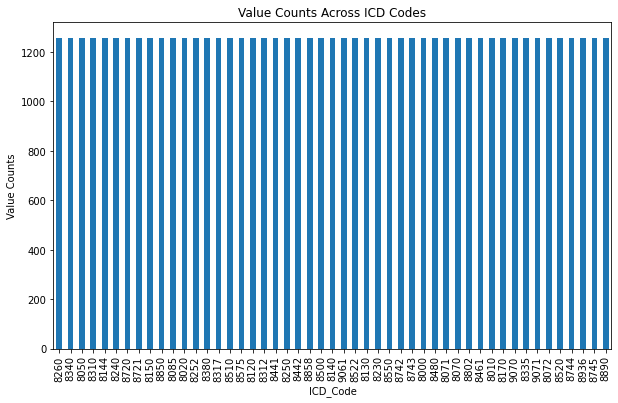

In [90]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6))
df_upsampled['Code'].value_counts().plot(ax=ax, kind='bar')
ax.set_xlabel("ICD_Code")
ax.set_ylabel("Value Counts")
ax.set_title("Value Counts Across ICD Codes");

In [91]:
'''
#Load the pretrained bert model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
'''

"\n#Load the pretrained bert model\nmodel_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')\n\n# Load pretrained model/tokenizer\ntokenizer = tokenizer_class.from_pretrained(pretrained_weights)\nmodel = model_class.from_pretrained(pretrained_weights)\n"

In [92]:
#df_upsampled.iloc[1392]

In [93]:
tokenized = df_upsampled["Dx"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [94]:
tokenized.iloc[1392]

[101, 13866, 13656, 2062, 2084, 4642, 1999, 4602, 9812, 102]

In [95]:
#pad everything to the same size! Set to the length of the largest input
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [96]:
#implement the attention mask
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(61593, 34)

In [97]:
input_ids = torch.tensor(padded)

In [98]:
#input_ids is the embedding of the sentence
print(len(input_ids))
print(len(df_upsampled))

61593
61593


In [99]:
index = 1
print(input_ids[index])
print(df_upsampled["Dx"][index])

tensor([  101, 17503,  2482, 21081,  2863,  1997,  2053,  2569,  2828, 17503,
        23245,  2389,  2482, 21081,  2863,  2025,  4728,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
1    squamous cell carcinoma usual type
1    squamous cell carcinoma usual type
1    squamous cell carcinoma usual type
1    squamous cell carcinoma usual type
1    squamous cell carcinoma usual type
1    squamous cell carcinoma usual type
Name: Dx, dtype: object


In [100]:
### Have to encode 0-9 each of the ICD Codes: 

In [101]:
#vectorize the Y keys to corresponding values:
y_train = df_upsampled["Code"].values
y_train = np.vectorize(icd_codes_d.get)(y_train)
y_train

array([18, 18, 18, ..., 41, 41, 41])

In [102]:
# train, dev, test: 

In [103]:
# train-test split:
test_size = int(np.floor(len(y_train)*.25))
rand_test_ints = np.random.randint(low=0, high=len(y_train), size=test_size)

y_dev = y_train[rand_test_ints]
y_train = np.delete(y_train, rand_test_ints, axis=0)

x_dev = input_ids[rand_test_ints]
x_train = np.delete(input_ids, rand_test_ints, axis=0)

In [104]:
y_train.shape, y_dev.shape

((47922,), (15398,))

In [105]:
#Format X, Y for input into NN: (For Dataloader)
train_data = []
for i in range(len(x_train)):
    train_data.append([x_train[i], y_train[i]])
    
dev_data = []
for i in range(len(x_dev)):
    dev_data.append([x_dev[i], y_dev[i]])

In [106]:
x_dev.shape

torch.Size([15398, 34])

# Classifying

In [107]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn

In [108]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()

        input_dim = 120
        hidden_1 = 50
        hidden_2 = 10
        
        self.fc1 = nn.Linear(input_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 120)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [109]:
class BLSTM(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        lstm_hidden_dim = 256
        lstm_num_layers = 1
        linear_output_dim =128
        output_dim = 10
        
        self.lstm = nn.LSTM(input_size=34, hidden_size=256,
                          num_layers=1, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.33)
        self.linear1 = nn.Linear(512, 128)
        self.elu = nn.ELU()
        self.linear2 = nn.Linear(128, 49)
        
        
    def forward(self, inputs):
        lstm_out, self.hidden = self.lstm(inputs.view(len(inputs), 1, -1))
        lstm_out_dropped = self.dropout(lstm_out)
        out = self.linear1(lstm_out_dropped.view(len(inputs), -1))
        elu_out = self.elu(out)
        l2_out = self.linear2(elu_out)
        log_probs = F.log_softmax(l2_out, dim=1)
        return log_probs

In [110]:
len(train_data)

47922

In [111]:
len(dev_data), len(test_data)

(15398, 1302)

In [112]:
n_epochs = 20
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=1)
devloader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=1)
blstm = BLSTM()
criterion = nn.CrossEntropyLoss(ignore_index=-1, size_average=True) #therefore no need for softmax
optimizer = torch.optim.SGD(blstm.parameters(), lr=0.001, momentum=0.7)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

test_loss_min = 10000

for epoch in range(n_epochs):
    #scheduler.step()
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    train_loss = 0
    test_loss = 0
    
    blstm.train()
    for data, target in trainloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
#         print(data)
#         print(target)
        #print(torch.cat(data,dim=0).reshape(1,400,316))
        #print(torch.cat(data,dim=0).size(0)) I think the problem is here.
        #print(data)
        output = blstm(data.float())

        # Compute loss
        loss = criterion(output, target)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

                # Print statistics
        #train_loss += loss.item()*torch.cat(data,dim=0).size(0)
        train_loss += loss.item()*data.size(0)
        
    with torch.no_grad():
        for data, target in devloader:
            output = blstm(data.float())
            loss = criterion(output, target)
#             test_loss += loss.item()*torch.cat(data,dim=0).size(0)
            test_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(trainloader.dataset)
    test_loss = test_loss/len(devloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    if test_loss <= test_loss_min:
        torch.save(blstm.state_dict(), 'blstm.pt')
        test_loss_min = test_loss

  # Process is complete.
print('All done.')


Epoch-0 lr: 0.001
Epoch: 1 	Training Loss: 3.013024 	Test Loss: 2.608394
Epoch-1 lr: 0.001
Epoch: 2 	Training Loss: 1.639790 	Test Loss: 1.583348
Epoch-2 lr: 0.001
Epoch: 3 	Training Loss: 0.883587 	Test Loss: 1.021511
Epoch-3 lr: 0.001
Epoch: 4 	Training Loss: 0.576519 	Test Loss: 0.716939
Epoch-4 lr: 0.001
Epoch: 5 	Training Loss: 0.426901 	Test Loss: 0.551203
Epoch-5 lr: 0.001
Epoch: 6 	Training Loss: 0.339306 	Test Loss: 0.432168
Epoch-6 lr: 0.001
Epoch: 7 	Training Loss: 0.279916 	Test Loss: 0.354717
Epoch-7 lr: 0.001
Epoch: 8 	Training Loss: 0.237744 	Test Loss: 0.296048
Epoch-8 lr: 0.001
Epoch: 9 	Training Loss: 0.202993 	Test Loss: 0.252656
Epoch-9 lr: 0.001
Epoch: 10 	Training Loss: 0.178659 	Test Loss: 0.218593
Epoch-10 lr: 0.001
Epoch: 11 	Training Loss: 0.158452 	Test Loss: 0.191776
Epoch-11 lr: 0.001
Epoch: 12 	Training Loss: 0.142382 	Test Loss: 0.168698
Epoch-12 lr: 0.001
Epoch: 13 	Training Loss: 0.128126 	Test Loss: 0.152889
Epoch-13 lr: 0.001
Epoch: 14 	Training Loss:

In [54]:
# Load in the best model from the given run:
blstm = BLSTM()
blstm.load_state_dict(torch.load('blstm.pt'))


In [113]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=1)

In [114]:
# Calculate Accuracy from trained model:
def predict(model, dataloader):
    prediction_list = []
    with torch.no_grad():
        for data, target in dataloader:
            output = model(data.float())
            _, predicted = torch.max(output.data, 1) 
            prediction_list.append(predicted)
    return prediction_list

In [115]:
def accuracy(y_true, y_pred):
    score = sum(y_true == y_pred)/len(y_pred)
    return score

In [116]:
predictions = predict(blstm, testloader)
predictions = np.array(predictions)

In [117]:
#See what it's actually predicting:
np.unique(predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [118]:
print("Test Accuracy:", accuracy(y_test, predictions))

Test Accuracy: 0.9715821812596006


In [119]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        51
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       0.80      0.94      0.86        17
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         6
           8       0.71      1.00      0.83         5
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         2
          11       0.93      0.96      0.95        27
          12       0.88      1.00      0.93         7
          13       0.96      1.00      0.98        44
          14       0.75      1.00      0.86         6
          15       0.70      1.00      0.82         7
          16       1.00      1.00      1.00         4
          17       0.86    

In [ ]:
### Obviously not good.

In [ ]:
predictions[0]

7

In [ ]:
y_test[0]

8

In [ ]:
dfs["preprocessed_ICD_codes"].values

array(['S18', 'S21', 'S21', ..., 'S19', 'S18', 'S19'], dtype=object)

In [ ]:
icd_codes_d

{'O17': 0,
 'O18': 5,
 'O19': 9,
 'O20': 6,
 'O21': 1,
 'S17': 4,
 'S18': 7,
 'S19': 8,
 'S20': 3,
 'S21': 2}

In [ ]:
x_test[0]

tensor([  101, 17503,  2482, 21081,  2863,  1997,  2053,  2569,  2828,  1006,
        23245,  2389,  1010,  2025,  4728,  9675,  1007,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
x_test[1]

tensor([  101, 13866,  1024, 13656,  2062,  2084,  4642,  1998,  2625,  2084,
         2030,  5020,  2000,  4642,  1999,  4602,  9812,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])